In [1]:
import numpy as np
import numpy.lib.stride_tricks
import math
from matplotlib import pyplot as plt

In [2]:
u = np.zeros((2,2,10))
w = np.zeros((1,2,10))

In [3]:
#Custom Functions

#Trapezoid Integration Function
def integrate(u,dx,x_vals):
    area_under_curve = 0
    for i in range(0,len(x_vals)-1):
        area = dx * (u[i+1]+u[i]) / 2
        area_under_curve = area_under_curve + area
    return area_under_curve

#Gaussian Function
def gaussian(x, mu, sigma):
    denom = sigma * ((2 * math.pi)**0.5)
    numerator = math.exp(((x - mu)**2) / ((sigma) **2) / -2)
    res = numerator / denom
    return res

# Habitat Preference
def preference(x):
    pi = math.pi
    res = -math.cos(pi*x/5) + 1.1 
    res = np.float64(res)
    return res

# 1st Derivative of Habitat Preference Function
def preference_slope(x):
    pi = math.pi
    res = pi/5*math.sin(pi*x/5)
    res = np.float64(res)
    return res

# 2nd Derivative of Habitat Preference Function
def preference_slope_slope(x):
    pi = math.pi
    res = (2*pi*pi/625) * math.cos(2*pi*x/25)# Example 1
    #res = -0.02 * ((-0.02 * math.exp(-0.01*(x-50)**2)*(x-50))*(x-50)+1*math.exp(-0.01*(x-50)**2)) # Example 2
    res = np.float64(res)
    return res

#Normalized RMSE

def rmse(model, true, nx, t):
    summation = 0
    for i in range(0,nx):
        dif = (model[t][1][i] - true[0][1][i])**2
        summation = summation + dif
    rmse = (summation/nx)**0.5
    return abs(rmse)

#Convergence Flag

def converge(current_t, t_minus1000, t_minus2000):
    #function to determine whether finite difference scheme has convered
    #inputs are rows of an array
    current_t = np.float128(current_t ** 0.01)
    t_minus50 = np.float128(t_minus1000 ** 0.01)
    t_minus100 = np.float128(t_minus2000 ** 0.01)
    h1 = abs(t_minus1000 - t_minus2000)
    print(h1)
    h2 = abs(current_t - t_minus1000)
    print(h2)
    dif = abs(h1-h2)
    print(dif)
    cuttoff = np.format_float_scientific(np.float128(1e-128), unique=False, precision=128)
    mask = dif>np.float128(cuttoff)
    print(mask)
    if True not in mask:
        print("yes")
        return True
    
#Sliding window
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        
    

In [4]:
#Model Settings

# Bounds
start = 0 # start bound
stop = 50 # stop bound


# Model parameters
dt = 0.01 # delta t
dx = 1  # delta x
T = 0.1 # Total time
Nt = int(T / dt)  # Number of time steps
Nx = int((abs(stop-start))/dx)  # Number of x steps
mean_sl = 0.04 #mean step length
k = (mean_sl**2)/2/dt # diffusion coefficient equal to mean step length squared
r = k * dt / dx / dx  # Fourier number

# Fourier Number Flag
if r > 0.5:
    print("Fourier Number " + str(r) +  " > 0.5. Adjust mean step length, dx, or dt")

In [5]:
# Initializing x values where u(x,t) will be calculated
Xs = np.arange(0, 11, dx)

# Initializing array with Nt row, Nx columns, and [x,u(x,t)] per cell
u = np.zeros((2, 2, len(Xs)))

#Habitat Preference Function
w = np.zeros((1,2,len(Xs)))
w[0][0] = Xs
for i in range(0,len(Xs)):
    w[0][1][i] = preference(w[0][0][i])

#First Spatial Derivative of Habitat Preference Function
wx = np.zeros((1,2,len(Xs)))
wx[0][0] = Xs
for i in range(0,len(Xs)):
    wx[0][1][i] = preference_slope(w[0][0][i])

#Second Spatial Derivative of Habitat Preference Function
wxx = np.zeros((1,2,len(Xs)))
wxx[0][0] = Xs
for i in range(0,len(Xs)):
    wxx[0][1][i] = preference_slope_slope(w[0][0][i])

#Velocity
c = np.zeros((1,2,len(Xs)))
c[0][0] = Xs
for i in range(0,len(Xs)):
    c[0][1][i] = ((mean_sl**2)/dt)*(wx[0][1][i]/w[0][1][i])
    
#First derivative of veloctiy
cx = np.zeros((1,2,len(Xs)))
cx[0][0] = Xs
for i in range(0,len(Xs)):
    cx[0][1][i] = ((mean_sl**2)/dt)*(((wxx[0][1][i]*w[0][1][i])-wx[0][1][i]**2)/(w[0][1][i]**2))

# Populating x values in array u
for j in range(0, 2):
    u[j][0]=Xs
    
# Setting Initial Condition
IC=[1,2,3,4,5,6,5,4,3,2,1]
u[0][1] = IC # Populating initial condition in array u

In [6]:
print(u)
print(w)

[[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
  [ 1.  2.  3.  4.  5.  6.  5.  4.  3.  2.  1.]]

 [[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]]
[[[ 0.          1.          2.          3.          4.
    5.          6.          7.          8.          9.
   10.        ]
  [ 0.1         0.29098301  0.79098301  1.40901699  1.90901699
    2.1         1.90901699  1.40901699  0.79098301  0.29098301
    0.1       ]]]


In [60]:
c_win = rolling_window(c[0][1],3)
u_win = rolling_window(u[0][1],3)
a = c_win * u_win
#Coefs from finite difference
advec_multipliers_cd = np.array([-1,0,1])
#Coefs from finite difference
advec_multipliers_posc = np.array([1,-4,3])
#Coefs from finite difference
advec_multipliers_negc = np.array([-1,4,-3])
#Coefs from finite difference
diffusion_multipliers = np.array([1,-2,1])

In [43]:
#c > 0 upwind

#Calculating Advection
advec_broad_posc = np.broadcast(a, advec_multipliers_posc)
advec_posc = np.empty(advec_broad_posc.shape)
advec_posc.flat = [-u*v/(2*dx) for (u,v) in advec_broad_posc]
advec_sum_posc = np.sum(advec_posc, axis = 1)
advec_posc = numpy.append([0,0],advec_sum_posc)


In [44]:


#Calculating Advection
advec_broad_negc = np.broadcast(a, advec_multipliers_negc)
advec_negc = np.empty(advec_broad_negc.shape)
advec_negc.flat = [-u*v/(2*dx) for (u,v) in advec_broad_negc]
advec_sum_negc = np.sum(advec_negc, axis = 1)
advec_negc = numpy.append(advec_sum_negc,[0,0])

#Calculating advection manually at edges



In [45]:
advec_posc

array([ 0.        ,  0.        ,  0.26834894,  0.11504425,  0.12938585,
        0.17382174,  0.15476714,  0.09760331,  0.07847413,  0.0196755 ,
       -0.63097606])

In [46]:
# c central dif



#Creating sliding window to calculate advection and diffusion at each spatial position 

#Calculating Advection
advec_broad_cd = np.broadcast(a, advec_multipliers_cd)
advec_cd = np.empty(advec_broad_cd.shape)
advec_cd.flat = [-u*v/(2*dx) for (u,v) in advec_broad_cd]
advec_sum_cd = np.sum(advec_cd, axis = 1)
advec_cd1 = np.append([0], advec_sum_cd)
advec_cd = np.append(advec_cd1,[0])



In [66]:
#assigning advection scheme
#1 = c>0
#0 = central difference
#-1 = c<0

csign_win = np.where(c_win < 0, -1,np.where(c_win>0,1,0))

posc_check1 = np.all(csign_win == 1, axis = 1)
posc_check = np.append([False,False],posc_check1)

negc_check1 = np.all(csign_win == -1, axis = 1)
negc_check = np.append(negc_check1, [False,False])

cd_check = np.where(negc_check == posc_check, True, False)
cd_check[0] = False
cd_check[-1] = False

advec_scheme = np.full((1,len(Xs)),-99)
advec_scheme = np.where(posc_check == True,1,np.where(negc_check == True,-1,np.where(cd_check == True, 0, advec_scheme[0][1])))

advection = np.zeros((1,len(Xs)))
advection = np.where(advec_scheme[0][1] == 1, advec_posc, 
                           np.where(advec_scheme[0][1] == 0, advec_cd,
                                   np.where(advec_scheme[0][1] == -1, advec_negc, -99)))

In [48]:
print(advection)

[[[ 0.00000000e+00  1.00000000e+00  2.00000000e+00  3.00000000e+00
    4.00000000e+00  5.00000000e+00  6.00000000e+00  7.00000000e+00
    8.00000000e+00  9.00000000e+00  1.00000000e+01]
  [-9.90000000e+01 -1.81313559e-01  6.73598762e-02  1.15044247e-01
    1.29385850e-01  1.73821744e-01 -7.84741325e-02 -1.96755050e-02
    6.30976058e-01 -1.81313559e-01 -9.90000000e+01]]]


In [49]:
csign_win

array([[ 0,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1, -1],
       [ 1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1]])

In [67]:
#Calculate advection manually at edges
csign = np.where(c[0][1] < 0, -1,np.where(c[0][1]>0,1,0))

#Left Edge
backward_csign = np.array([csign[0],csign[-1], csign[-2]])
if advection[0] == -99 and sum(backward_csign) == 3:
    backward_u = np.array([u[0][1][-2], u[0][1][-1], u[0],[1],[0]])
    backward_c = np.array([c[0][1][-2], c[0][1][-1]])
    advec = backward_c * advec_multipliers_posc * backward_u * (-1/(2*dx))
    advec_sum = sum(advec)
    advection[0] = advec_sum
else:
    center_left_u = np.array([u[0][1][-1], u[0][1][0], u[0][1][1]])
    center_left_c = np.array([c[0][1][-1], c[0][1][0], c[0][1][1]])
    advec = center_left_u * center_left_c * advec_multipliers_cd * (-1/(2*dx))
    advec_sum = sum(advec)
    advection[0] = advec_sum
                           
#Right Edge
forward_csign = np.array([csign[-1],csign[0], csign[1]])
if advection[-1] == -99 and sum(forward_csign) == -3:
    forward_u = np.array([u[0][1][-1], u[0][1][0], u[0][1][1]])
    forward_c =  np.array([c[0][1][-1], c[0][1][0], c[0][1][1]])
    advec = forward_c * advec_multipliers_negc * forward_u * (-1/(2*dx))
    advec_sum = sum(advec)
    advection[-1] = advec_sum
else:
    center_right_u = np.array([u[0][1][-2], u[0][1][-1], u[0][1][0]])
    center_right_c = np.array([c[0][1][-2], c[0][1][-1], c[0][1][0]])
    advec = center_left_u * center_left_c * advec_multipliers_cd * (-1/(2*dx))
    advec_sum = sum(advec)
    advection[-1] = advec_sum


In [68]:
#Adding c'(i) * u(i,j) to advection term
advection += u[0][1] * cx[0][1]


In [71]:
#Calculating Diffusion
dif_broad = np.broadcast(u_win,diffusion_multipliers)
dif = np.empty(dif_broad.shape)
dif.flat = [u*v/(2*dx) for (u,v) in dif_broad]
dif_sum = np.sum(dif, axis = 1)
dif1 = np.append([0], dif_sum)
diffusion = np.append(dif1, [0])



In [73]:
diffusion

array([ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.])

In [75]:
#Calculaing Diffusion manually at edges
center_left_u = np.array([u[0][1][-1], u[0][1][0], u[0][1][1]])
dif_left = center_left_u * diffusion_multipliers * (1/(2*dx))
dif_left_sum = sum(dif_left)
diffusion[0] = dif_left_sum

center_right_u = np.array([u[0][1][-2], u[0][1][-1], u[0][1][0]])
dif_right = center_right_u * diffusion_multipliers * (1/(2*dx))
dif_right_sum = sum(dif_right)
diffusion[0] = dif_right_sum

In [76]:
#calculating u at time (j+1)
u[1][1] = u[0][1] + dt * (advection + diffusion)

In [ ]:
#wx< 0

#Coefs from finite difference
diffusion_multipliers = np.array([1,-2,1,0])
advection_multipliers = np.array([0,-3,4,-1])

#Masking values in current timestep where c > 0
c_mask = np.where(wx[0][1]<0, u[0][1], 0)
u_mask = c_mask * u

#Creating sliding window to calculate advection and diffusion at each spatial position 
u_win = rolling_window(u_mask[0][1],4)
w_win = rolling_window(w[0][1],4)

#Calculating advection
advec_broad = np.broadcast(u_win,w_win,advection_multipliers)
advec = np.empty(advec_broad.shape)
advec.flat = [-t*u*v/(2*dx) for (t,u,v) in advec_broad]
advection_neg_c = np.sum(advec, axis = 1)

#Calculating diffusion
dif_broad = np.broadcast(u_win,diffusion_multipliers)
dif = np.empty(dif_broad.shape)
dif.flat = [u*v/(2*dx) for (u,v) in dif_broad]
diffusion_neg_c= np.sum(dif, axis = 1)

In [78]:
print(u[0][1])
print(u[1][1])

[1. 2. 3. 4. 5. 6. 5. 4. 3. 2. 1.]
[1.0034746  1.99336847 2.998102   4.0001039  5.00106537 5.99178283
 4.99892416 3.99862525 3.00348861 1.99281067 0.99756046]


<function matplotlib.pyplot.show(close=None, block=None)>

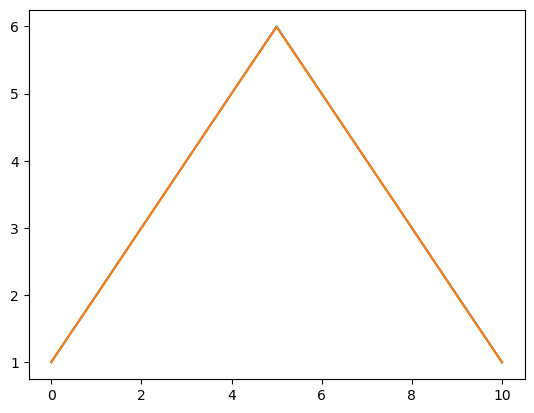

In [77]:
plt.plot(Xs, u[0][1])
plt.plot(Xs, u[1][1])
plt.show